In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import logging
import numpy as np
from json import JSONDecodeError
%matplotlib inline
%config IPCompleter.greedy=True

In this project our goal is to predict sales on a product and store level over the next month. Let's first take a look at the data. We start with items:

In [2]:
items = pd.read_csv('items.csv')
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [3]:
items.shape

(22170, 3)

Straightforward - we have item names and IDs, as well as a category ID. A big complication is that many of the names are Russian! We will want to translate these if we want to build some NLP features.

Category should come in useful as a way to group similar items together; intuitively similar items will trend in sales in a related way. Here are the categories:

In [4]:
cats = pd.read_csv('item_categories.csv')
cats.head(25)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [5]:
cats.shape

(84, 2)

Looks to be electronics shops. Happily we have that consistency in theme. It would be complex if we had, say, groceries as another category, as those products should trend in sales in a drastically different way from the electronics. 
Still, it might be worth doing some grouping on these category names; all the console stuff could maybe go together as just video games, for example. Or maybe group all the PS2 stuff together; all PS2-related sales should be declining together as the console ages.

Now let's look at shops:

In [6]:
shops = pd.read_csv('shops.csv')
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [7]:
shops.shape

(60, 2)

Simply shop names and IDs. Again we will probably want to do some translation here.

Finally let's look at the training set:

In [8]:
sales = pd.read_csv('sales_train.csv.gz')
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [9]:
sales.shape

(2935849, 6)

Finally some numeric features!

In [10]:
sales['item_price'].describe()

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

These prices seem oddly high, but they're probably in rubles. Still, the max price of 307,980 seems fishy. The negative price is also clearly some kind of data issue. First we look at the max price item:

In [11]:
items[items['item_id'] == sales.sort_values(['item_price'], ascending=False).iloc[0]['item_id']]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [12]:
cats[cats['item_category_id'] == 75]

,item_category_name,item_category_id
75,Программы - Для дома и офиса,75


In [13]:
sales[sales['item_id'] == sales.sort_values(['item_price'], ascending=False).iloc[0]['item_id']]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


The item name is very vague, but the category seems to be software programs for home/office. 
Honestly just one weird row like this probably won't matter, especially since this item has seen only one sale ever. I would feel extremely safe just assigning it 0 sales.

In [14]:
items[items['item_id'] == sales.sort_values(['item_price']).iloc[0]['item_id']]

,item_name,item_id,item_category_id
2973,"DmC Devil May Cry [PS3, русские субтитры]",2973,19


The min price item is a video game. Clearly an error - I don't think a game can be so bad people need to be paid to play it!

In [15]:
sales['item_cnt_day'].describe()

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

Clearly negative sales count is an error we should also be removing.

Let's start cleaning the data.

In [16]:
train = sales
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


We also want to do all of these transformations on the test set, so let's pull that in now.

In [17]:
test = pd.read_csv('test.csv.gz')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [18]:
test.shape

(214200, 3)

Let's explore the test set a little bit first.

In [19]:
train_comb = train.groupby(['shop_id', 'item_id']).size().reset_index().rename(columns={0:'count'})
train_comb['ID'] = train_comb['shop_id'].astype(str) + '-' + train_comb['item_id'].astype(str)

First - are there any new shops in the test set?

In [20]:
len(set(test['shop_id'].unique()) - set(train['shop_id'].unique()))

0

Thankfully not. Are there new items?

In [21]:
len(set(test['item_id'].unique()) - set(train['item_id'].unique()))

363

There are. This is problematic. 

In [22]:
len(set(test['shop_id'].astype(str) + '-' + test['item_id'].astype(str)) - set(train_comb['ID']))

102796

There are many new item-shop combinations as well. Dealing with these issues will be critical to our success.

Now let's fix the date format and remove negatives as we mentioned previously.

In [23]:
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')

In [24]:
train = train[train['item_price'] > 0]
train = train[train['item_cnt_day'] > 0]
train.shape

(2928492, 6)

In [25]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0


Let's explore the timeseries dynamics. Here are the overall sales trends.

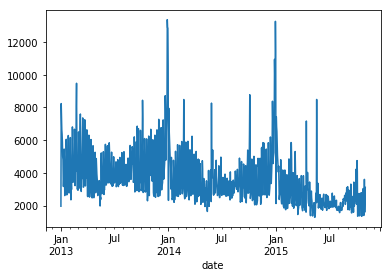

In [26]:
train.groupby(by=['date'])['item_cnt_day'].sum().plot()

Very noisy - let's smooth things out with a rolling sum.

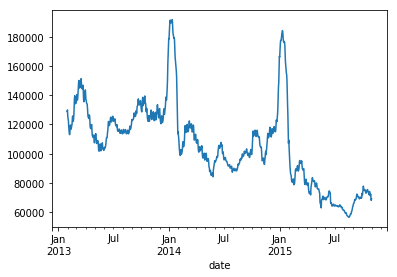

In [27]:
train.groupby(by=['date'])['item_cnt_day'].sum().rolling(30).sum().plot()

Clear seasonality - huge spikes in the holiday months, as well as what potentially looks like end-of-quarter spikes in sales. Sales seem to decline slowly over a quarter otherwise.

Furthermore it looks like overall YoY sales are declining.

For date itself, a few obvious features to create are year/month/quarter. Since our goal is to predict monthly sales, we will ultimately want to aggregate out day and week.

For shop ID, let's look at sales over time by shop. Perhaps some shops are already closed!

(0, 4000)

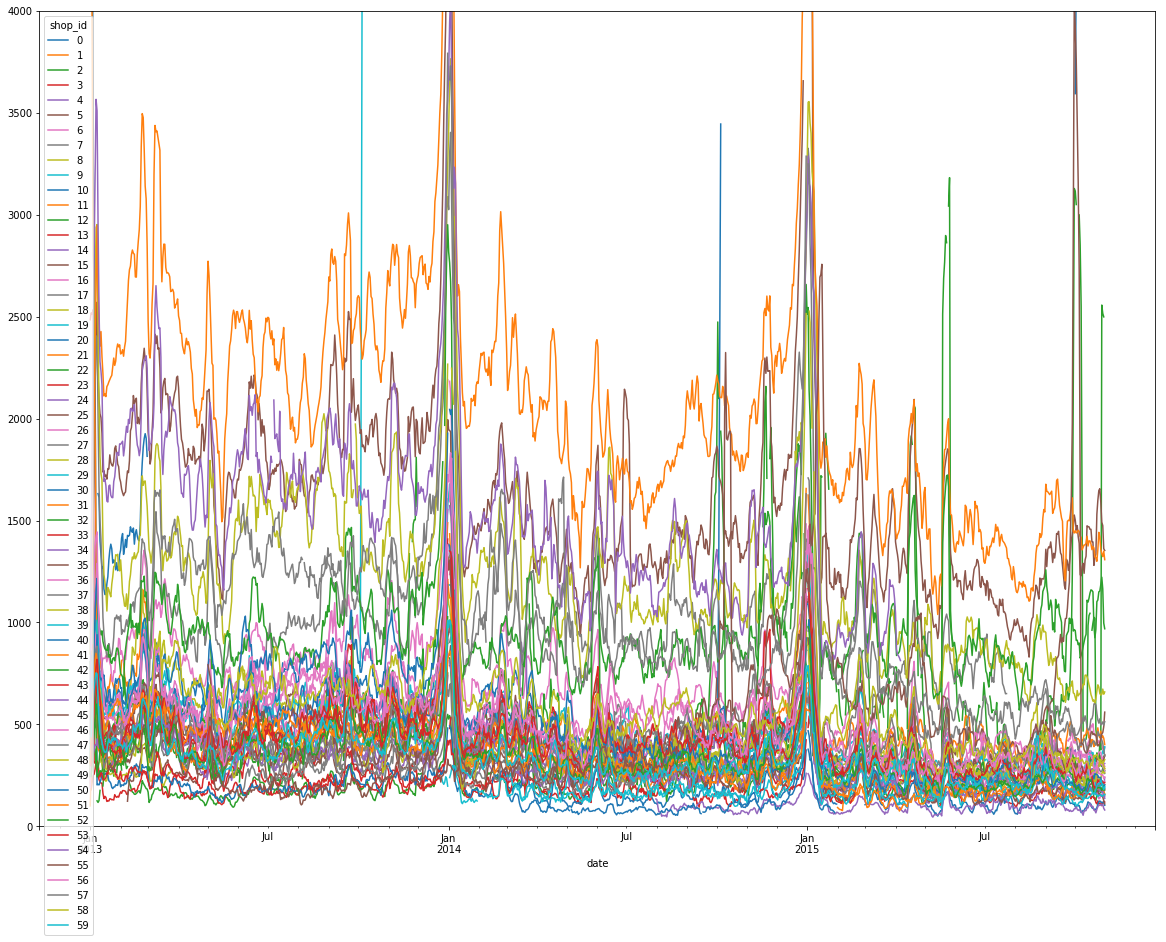

In [28]:
train.groupby(by=['shop_id', 'date'])['item_cnt_day'].sum().rolling(7).sum().unstack(0).plot(legend=True, figsize=(20, 15))
plt.ylim(0, 4000)

Looks like all shops are alive and selling some products. Now let's look at item ids. There are bound to be items that have not been selling well recently - we saw the categories; some are for really old merchandise like PS2 accessories. We can probably write off products with no sales in the last few months and project those to be 0.

In [29]:
train['date'].max() - np.timedelta64(6, 'M')

Timestamp('2015-05-01 09:05:24')

In [30]:
items_with_sales = train[train['date'] >= train['date'].max() - np.timedelta64(6, 'M')].groupby(by=['item_id', 'date'])['item_cnt_day'].sum().reset_index()['item_id'].unique()
len(items_with_sales)

8890

Now let's do some feature engineering!

In [31]:
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['quarter'] = np.floor((train['month']-.1)/3) + 1

In [32]:
average_item_prices = train.groupby(['item_id'])['item_price'].mean().fillna(0).reset_index().rename(columns={'item_price' : 'mean_price_item'})
sd_item_prices = train.groupby(['item_id'])['item_price'].std().fillna(0).reset_index().rename(columns={'item_price' : 'sd_price_item'})
average_item_prices_shop = train.groupby(['shop_id', 'item_id'])['item_price'].mean().fillna(0).reset_index().rename(
    columns={'item_price' : 'mean_price_item_shop'})
sd_item_prices_shop = train.groupby(['shop_id', 'item_id'])['item_price'].std().fillna(0).reset_index().rename(
    columns={'item_price' : 'sd_price_item_shop'})

In [33]:
df = train.groupby(['date_block_num', 
               'shop_id', 
               'item_id', 
               'year', 
               'month', 
               'quarter'])['item_cnt_day'].sum().reset_index().rename(
    columns={'item_cnt_day' : 'item_cnt_month'})
df = pd.merge(df, items, on='item_id')
df = pd.merge(df, average_item_prices, on=['item_id'])
df = pd.merge(df, sd_item_prices, on=['item_id'])
df = pd.merge(df, average_item_prices_shop, on=['item_id', 'shop_id'])
df = pd.merge(df, sd_item_prices_shop, on=['item_id', 'shop_id'])
df.head()

,date_block_num,shop_id,item_id,year,month,quarter,item_cnt_month,item_name,item_category_id,mean_price_item,sd_price_item,mean_price_item_shop,sd_price_item_shop
0,0,0,32,2013,1,1.0,6.0,1+1,40,249.736179,99.997444,221.000000,0.000000
1,1,0,32,2013,2,1.0,10.0,1+1,40,249.736179,99.997444,221.000000,0.000000
2,0,1,32,2013,1,1.0,7.0,1+1,40,249.736179,99.997444,221.000000,0.000000
3,1,1,32,2013,2,1.0,3.0,1+1,40,249.736179,99.997444,221.000000,0.000000
4,0,3,32,2013,1,1.0,3.0,1+1,40,249.736179,99.997444,242.333333,103.279556


In [34]:
months_active = df.groupby(['item_id', 'date_block_num'])['month'].count().reset_index().drop(['month'], axis=1).groupby(
    'item_id').count().reset_index().rename(columns={'date_block_num' : 'months_active'})
months_active_shop = df.groupby(['shop_id', 'item_id', 'date_block_num'])['month'].count().reset_index().drop(['month'], axis=1).groupby(
    ['shop_id', 'item_id']).count().reset_index().rename(columns={'date_block_num' : 'months_active'})

In [35]:
def consecutive_sequence_length(x):
     return len(max(np.split(x, np.where(np.diff(x) != 1)[0]+1), key=len))

In [36]:
consecutive_months_active = df.groupby(['item_id', 'date_block_num'])['month'].count().reset_index().drop(['month'], axis=1)
consecutive_months_active = consecutive_months_active.groupby(['item_id'])['date_block_num'].apply(consecutive_sequence_length)
consecutive_months_active = consecutive_months_active.to_frame().reset_index().rename(columns={'date_block_num' : 'consecutive_months'})
consecutive_months_active_shop = df.groupby(['shop_id', 'item_id', 'date_block_num'])['month'].count().reset_index().drop(['month'], axis=1)
consecutive_months_active_shop = consecutive_months_active_shop.groupby(['shop_id', 'item_id'])['date_block_num'].apply(consecutive_sequence_length)
consecutive_months_active_shop = consecutive_months_active_shop.to_frame().reset_index().rename(columns={'date_block_num' : 'consecutive_months_shop'})

In [37]:
recent_date = df.groupby(['item_id'])['date_block_num'].max()
recent_date = recent_date.to_frame().reset_index().rename(columns={'date_block_num' : 'recent_date'})
recent_date_shop = df.groupby(['shop_id', 'item_id'])['date_block_num'].max()
recent_date_shop = recent_date_shop.to_frame().reset_index().rename(columns={'date_block_num' : 'recent_date_shop'})
recent_date['last_six'] = recent_date['recent_date'] >= 28
recent_date_shop['last_six_shop'] = recent_date_shop['recent_date_shop'] >= 28

In [38]:
df = pd.merge(df, consecutive_months_active, on=['item_id'])
df = pd.merge(df, consecutive_months_active_shop, on=['shop_id', 'item_id'])
df = pd.merge(df, recent_date, on=['item_id'])
df = pd.merge(df, recent_date_shop, on=['shop_id', 'item_id'])

In [39]:
train = pd.merge(train, items, on='item_id')
category_means = train.groupby('item_category_id')['item_price'].mean().fillna(0).reset_index().rename(columns={'item_price' : 'mean_category_price'})
category_sds = train.groupby('item_category_id')['item_price'].std().fillna(0).reset_index().rename(columns={'item_price' : 'sd_category_price'})
category_means_shop = train.groupby(['item_category_id', 'shop_id'])['item_price'].mean().fillna(0).reset_index().rename(
    columns={'item_price' : 'mean_category_price_shop'})
category_sds_shop = train.groupby(['item_category_id', 'shop_id'])['item_price'].std().fillna(0).reset_index().rename(
    columns={'item_price' : 'sd_category_price_shop'})

In [40]:
test['month'] = 11
test['quarter'] = 4
test['year'] = 2015
test['date_block_num'] = 34
test = pd.merge(test, items, on='item_id')

In [41]:
test = pd.merge(test, average_item_prices, on=['item_id'], how='left')
test = pd.merge(test, sd_item_prices, on=['item_id'], how='left')
test = pd.merge(test, average_item_prices_shop, on=['item_id', 'shop_id'], how='left')
test = pd.merge(test, sd_item_prices_shop, on=['item_id', 'shop_id'], how='left')

In [42]:
test = pd.merge(test, category_means, on=['item_category_id'])
test = pd.merge(test, category_sds, on=['item_category_id'])
test = pd.merge(test, category_means_shop, on=['item_category_id', 'shop_id'], how='left')
test = pd.merge(test, category_sds_shop, on=['item_category_id', 'shop_id'], how='left')

In [43]:
test['mean_price_item'] = np.where(test['mean_price_item'].isna(), test['mean_category_price'], test['mean_price_item'])
test['sd_price_item'] = np.where(test['sd_price_item'].isna(), test['sd_category_price'], test['sd_price_item'])
test['mean_price_item_shop'] = np.where(test['mean_price_item_shop'].isna(), test['mean_category_price_shop'], test['mean_price_item_shop'])
test['sd_price_item_shop'] = np.where(test['sd_price_item_shop'].isna(), test['sd_category_price_shop'], test['sd_price_item_shop'])
test['mean_price_item_shop'] = np.where(test['mean_price_item_shop'].isna(), test['mean_category_price'], test['mean_price_item_shop'])
test['sd_price_item_shop'] = np.where(test['sd_price_item_shop'].isna(), test['sd_category_price'], test['sd_price_item_shop'])

In [44]:
test.drop(['mean_category_price', 'sd_category_price', 'mean_category_price_shop', 'sd_category_price_shop'], axis=1, inplace=True)
test.head()

,ID,shop_id,item_id,month,quarter,year,date_block_num,item_name,item_category_id,mean_price_item,sd_price_item,mean_price_item_shop,sd_price_item_shop
0,0,5,5037,11,4,2015,34,"NHL 15 [PS3, русские субтитры]",19,1923.611577,655.387747,1633.692308,639.671418
1,5100,4,5037,11,4,2015,34,"NHL 15 [PS3, русские субтитры]",19,1923.611577,655.387747,1836.583333,778.063854
2,10200,6,5037,11,4,2015,34,"NHL 15 [PS3, русские субтитры]",19,1923.611577,655.387747,2213.705882,598.374022
3,15300,3,5037,11,4,2015,34,"NHL 15 [PS3, русские субтитры]",19,1923.611577,655.387747,2241.105263,523.148364
4,20400,2,5037,11,4,2015,34,"NHL 15 [PS3, русские субтитры]",19,1923.611577,655.387747,1857.375000,636.971425


In [45]:
test = pd.merge(test, consecutive_months_active, on=['item_id'], how='left')
test = pd.merge(test, consecutive_months_active_shop, on=['shop_id', 'item_id'], how='left')
test.loc[test['consecutive_months'].isna(), 'consecutive_months'] = 1
test.loc[test['consecutive_months_shop'].isna(), 'consecutive_months_shop'] = 1

In [46]:
test = pd.merge(test, recent_date, on=['item_id'], how='left')
test = pd.merge(test, recent_date_shop, on=['shop_id', 'item_id'], how='left')
test.loc[test['recent_date'].isna(), 'recent_date'] = 34
test.loc[test['recent_date_shop'].isna(), 'recent_date_shop'] = 34
test.loc[test['last_six'].isna(), 'last_six'] = False
test.loc[test['last_six_shop'].isna(), 'last_six_shop'] = False

In [47]:
test[test.isnull().any(axis=1)]

,ID,shop_id,item_id,month,quarter,year,date_block_num,item_name,item_category_id,mean_price_item,sd_price_item,mean_price_item_shop,sd_price_item_shop,consecutive_months,consecutive_months_shop,recent_date,last_six,recent_date_shop,last_six_shop


In [48]:
df = pd.merge(df, cats, on='item_category_id')
df = pd.merge(df, shops, on='shop_id')
test = pd.merge(test, cats, on='item_category_id')
test = pd.merge(test, shops, on='shop_id')

Now let's do translation. Unfortunately due to rate-limiting we will skip over translating the item names in favor of the category names.

In [49]:
from googletrans import Translator
from time import sleep

def translate(text, translator, dct):
    if text in dct.keys():
        out = dct[text]
    else:
        try:
            out = translator.translate(text).text
            dct[text] = out
        except JSONDecodeError:
            logging.warning(text)
            out = 'NA'
        sleep(1)
    return out

trans = Translator()
dct = {}

In [50]:
%%time
df['shop_name_t'] = df['shop_name'].apply(translate, translator=trans, dct=dct)
test['shop_name_t'] = test['shop_name'].apply(translate, translator=trans, dct=dct)
df['item_category_name_t'] = df['item_category_name'].apply(translate, translator=trans, dct=dct)
test['item_category_name_t'] = test['item_category_name'].apply(translate, translator=trans, dct=dct)

CPU times: user 6.93 s, sys: 96.6 ms, total: 7.02 s
Wall time: 2min 41s


In [51]:
%%time
df['item_category_name_t'] = df['item_category_name'].apply(translate, translator=trans, dct=dct)

CPU times: user 976 ms, sys: 7.48 ms, total: 983 ms
Wall time: 982 ms


In [52]:
cols = ['year', 'month', 'quarter', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'shop_name_t', 'item_category_name_t',
        'mean_price_item', 'sd_price_item', 'mean_price_item_shop', 'sd_price_item_shop', 'consecutive_months', 'consecutive_months_shop', 
        'recent_date', 'last_six', 'recent_date_shop', 'last_six_shop']
target = df['item_cnt_month']
df = df[cols]
test = test[cols]
print(df.shape)
print(test.shape)

(1608226, 19)
(214200, 19)


In [53]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack, vstack
preprocess = make_column_transformer(
    (['mean_price_item', 'sd_price_item', 'mean_price_item_shop', 'sd_price_item_shop'], StandardScaler()),
    (['year', 'month', 'quarter', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'last_six', 'last_six_shop', 
      'consecutive_months', 'consecutive_months_shop', 'recent_date', 'recent_date_shop'], OneHotEncoder(categories='auto', handle_unknown='ignore'))
)
vectorizer_shops = TfidfVectorizer(ngram_range=(1,3))
vectorizer_cats = TfidfVectorizer(ngram_range=(1,3))

/usr/local/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:751: DeprecationWarning: `make_column_transformer` now expects (transformer, columns) as input tuples instead of (columns, transformer). This has been introduced in v0.20.1. `make_column_transformer` will stop accepting the deprecated (columns, transformer) order in v0.22.
  warnings.warn(message, DeprecationWarning)


In [54]:
X_train, X_val, y_train, y_val = train_test_split(df, target, random_state=3)
X_test = test
cols_nontext = ['year', 'month', 'quarter', 'date_block_num', 'shop_id', 'item_category_id', 'item_id',
                'mean_price_item', 'sd_price_item', 'mean_price_item_shop', 'sd_price_item_shop', 'consecutive_months', 'consecutive_months_shop', 
                'recent_date', 'last_six', 'recent_date_shop', 'last_six_shop']

In [55]:
%%time
X_train_sparse = hstack((preprocess.fit_transform(X_train[cols_nontext]), 
                         vectorizer_shops.fit_transform(X_train['shop_name_t']),
                         vectorizer_cats.fit_transform(X_train['item_category_name_t'])))
X_val_sparse = hstack((preprocess.transform(X_val[cols_nontext]), 
                       vectorizer_shops.transform(X_val['shop_name_t']),
                       vectorizer_cats.transform(X_val['item_category_name_t'])))
X_test_sparse = hstack((preprocess.transform(X_test[cols_nontext]), 
                        vectorizer_shops.transform(X_test['shop_name_t']),
                        vectorizer_cats.transform(X_test['item_category_name_t'])))

CPU times: user 43.2 s, sys: 2.04 s, total: 45.2 s
Wall time: 45.3 s


In [56]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import KFold, RandomizedSearchCV, TimeSeriesSplit

In [57]:
ridge = Ridge()

In [58]:
%%time
ridge.fit(X_train_sparse, y_train)

CPU times: user 4min 49s, sys: 768 ms, total: 4min 50s
Wall time: 4min 50s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [61]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_val, ridge.predict(X_val_sparse))

1.4946669184837862

In [64]:
cv = TimeSeriesSplit(n_splits=5)
param_grid = {'alpha':np.logspace(-4, 4, 10)}
ridgeSearch = RandomizedSearchCV(ridge, param_grid, scoring='neg_mean_absolute_error', verbose=1, cv=cv, n_jobs=-1)

In [65]:
%%time
ridgeSearch.fit(X_train_sparse, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 21.4min finished


CPU times: user 4min 40s, sys: 1.93 s, total: 4min 42s
Wall time: 26min 5s


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   error_score='raise-deprecating',
                   estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'alpha': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='neg_mean_absolute_error',
                   verbose=1)

In [66]:
ridgeSearch.best_params_

{'alpha': 21.54434690031882}

In [75]:
ridgeSearch.cv_results_['params']

[{'alpha': 0.0001},
 {'alpha': 0.000774263682681127},
 {'alpha': 0.005994842503189409},
 {'alpha': 0.046415888336127774},
 {'alpha': 0.3593813663804626},
 {'alpha': 2.782559402207126},
 {'alpha': 21.54434690031882},
 {'alpha': 166.81005372000558},
 {'alpha': 1291.5496650148827},
 {'alpha': 10000.0}]

In [76]:
[x['alpha'] for x in ridgeSearch.cv_results_['params']]

[0.0001,
 0.000774263682681127,
 0.005994842503189409,
 0.046415888336127774,
 0.3593813663804626,
 2.782559402207126,
 21.54434690031882,
 166.81005372000558,
 1291.5496650148827,
 10000.0]

In [70]:
ridgeSearch.cv_results_['mean_test_score']

array([-1.53278633, -1.53279255, -1.53274301, -1.53249186, -1.53058206,
       -1.52199942, -1.51039183, -1.51469479, -1.54622997, -1.5778891 ])

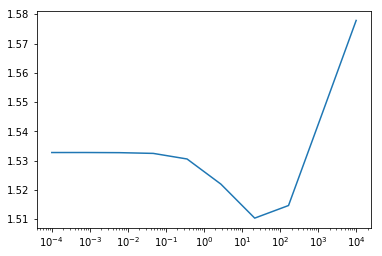

In [82]:
plt.plot([x['alpha'] for x in ridgeSearch.cv_results_['params']], -ridgeSearch.cv_results_['mean_test_score'])
plt.xscale('log')